In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from google.colab import drive
import cv2
from PIL import Image
import gc

In [2]:
# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")


✅ GPU memory growth enabled


In [3]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [4]:
import zipfile
import os

# ZIP file path in Google Drive
zip_path = "/content/drive/MyDrive/GAN/GAN.zip"

# Temporary extraction folder in Colab VM
extract_path = "/content/GAN_temp"
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to Colab VM:", extract_path)
print("Top-level folders:", os.listdir(extract_path))

✅ Extracted to Colab VM: /content/GAN_temp
Top-level folders: ['GAN']


In [17]:
# ==================== CONFIGURATION ====================
class Config:
    # Paths - Using local /content for faster training
    DATASET_PATH = '/content/GAN_temp/GAN/CUB_200_2011'
    EMBEDDINGS_PATH = '/content/GAN_temp/GAN/birds/train/char-CNN-RNN-embeddings.pickle'
    CHECKPOINT_DIR = '/content/drive/MyDrive/stackgan_checkpoints'

    # Google Drive backup paths (for saving final models)
    DRIVE_BACKUP_DIR = '/content/drive/MyDrive/StackGAN_Models'

    # Model hyperparameters
    TEXT_EMBEDDING_DIM = 1024  # CNN embedding dimension
    CONDITIONING_DIM = 128  # Conditioning augmentation output
    Z_DIM = 100  # Noise dimension
    GF_DIM = 128  # Generator feature dimension
    DF_DIM = 64  # Discriminator feature dimension

    # Training parameters
    BATCH_SIZE = 32  # Reduced from 64 for better memory usage
    EPOCHS_STAGE1 = 500
    EPOCHS_STAGE2 = 10
    LEARNING_RATE = 0.0002
    BETA1 = 0.5

    # Image sizes
    IMAGE_SIZE_STAGE1 = 64
    IMAGE_SIZE_STAGE2 = 256

    # Conditioning augmentation
    CA_LAMBDA = 1.0

    # Checkpoint settings
    CHECKPOINT_FREQUENCY = 50  # Save every N epochs
    RESUME_TRAINING = True  # Set to True to resume from checkpoint
    RESUME_STAGE = 1  # Which stage to resume (1 or 2)

config = Config()


In [18]:
# ==================== DATA LOADING ====================
def load_embeddings(embeddings_path):
    """Load pre-computed text embeddings"""
    print(f"Loading embeddings from {embeddings_path}...")
    with open(embeddings_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
    return embeddings

def get_image_paths(dataset_path):
    """Get all image file paths without loading them"""
    image_paths = []
    image_dir = os.path.join(dataset_path, 'images')

    print(f"Scanning images from {image_dir}...")
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(root, file)
                image_paths.append(img_path)

    return image_paths

def load_and_preprocess_image(image_path, target_size=(64, 64)):
    """Load and preprocess a single image on-the-fly"""
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def create_tf_dataset(image_paths, embeddings, batch_size, target_size=(64, 64)):
    """Create memory-efficient TensorFlow dataset with on-the-fly loading"""

    def load_image(path):
        """TensorFlow function to load image"""
        def _load_fn(p):
            p = p.numpy().decode('utf-8')
            img = load_and_preprocess_image(p, target_size)
            if img is None:
                img = np.zeros((target_size[0], target_size[1], 3), dtype=np.float32)
            return img.astype(np.float32)

        img = tf.py_function(_load_fn, [path], tf.float32)
        img.set_shape([target_size[0], target_size[1], 3])
        return img

    # Create dataset from paths
    path_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Map loading function
    image_dataset = path_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Create embedding dataset
    embedding_dataset = tf.data.Dataset.from_tensor_slices(embeddings)

    # Zip together
    dataset = tf.data.Dataset.zip((image_dataset, embedding_dataset))

    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [19]:
# ==================== CONDITIONING AUGMENTATION ====================
class ConditioningAugmentation(layers.Layer):
    """Conditioning Augmentation Network"""
    def __init__(self, conditioning_dim):
        super(ConditioningAugmentation, self).__init__()
        self.conditioning_dim = conditioning_dim
        self.fc = layers.Dense(conditioning_dim * 2)

    def call(self, text_embedding, training=False):
        # Handle embeddings with shape (batch, num_embeddings, embedding_dim)
        # Average pool to get (batch, embedding_dim)
        if len(text_embedding.shape) == 3:
            text_embedding = tf.reduce_mean(text_embedding, axis=1)

        x = self.fc(text_embedding)
        mu = x[:, :self.conditioning_dim]
        log_sigma = x[:, self.conditioning_dim:]

        if training:
            epsilon = tf.random.normal(shape=tf.shape(mu))
            c_code = mu + tf.exp(log_sigma) * epsilon
            return c_code, mu, log_sigma
        else:
            return mu, mu, log_sigma

    def kl_loss(self, mu, log_sigma):
        """KL divergence loss for conditioning augmentation"""
        loss = -log_sigma + 0.5 * (tf.exp(2 * log_sigma) + tf.square(mu) - 1)
        return tf.reduce_mean(loss)


In [20]:
# ==================== STAGE-I GENERATOR ====================
def build_stage1_generator(z_dim, conditioning_dim, gf_dim):
    """Stage-I Generator: Text + Noise -> 64x64 image"""

    # Inputs
    z_input = layers.Input(shape=(z_dim,), name='z_input')
    c_input = layers.Input(shape=(conditioning_dim,), name='conditioning_input')

    # Concatenate noise and conditioning
    x = layers.Concatenate()([z_input, c_input])

    # Project and reshape
    x = layers.Dense(gf_dim * 8 * 4 * 4, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4, 4, gf_dim * 8))(x)

    # Upsample to 8x8
    x = layers.Conv2DTranspose(gf_dim * 4, 4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsample to 16x16
    x = layers.Conv2DTranspose(gf_dim * 2, 4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsample to 32x32
    x = layers.Conv2DTranspose(gf_dim, 4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsample to 64x64
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', use_bias=False)(x)
    output = layers.Activation('tanh')(x)

    model = keras.Model(inputs=[z_input, c_input], outputs=output, name='Stage1_Generator')
    return model


In [21]:
# ==================== STAGE-I DISCRIMINATOR ====================
def build_stage1_discriminator(image_size, conditioning_dim, df_dim):
    """Stage-I Discriminator: 64x64 image + text -> Real/Fake"""

    # Image input
    img_input = layers.Input(shape=(image_size, image_size, 3), name='image_input')

    # Downsampling
    x = layers.Conv2D(df_dim, 4, strides=2, padding='same')(img_input)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 2, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 4, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 8, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Conditioning input
    c_input = layers.Input(shape=(conditioning_dim,), name='conditioning_input')

    # Replicate conditioning to spatial dimensions
    c_expand = layers.Dense(4 * 4 * df_dim * 8)(c_input)
    c_expand = layers.Reshape((4, 4, df_dim * 8))(c_expand)

    # Concatenate image features with conditioning
    x = layers.Concatenate()([x, c_expand])

    # Final convolution
    x = layers.Conv2D(df_dim * 8, 1, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output
    x = layers.Conv2D(1, 4, strides=4, padding='same')(x)
    output = layers.Flatten()(x)

    model = keras.Model(inputs=[img_input, c_input], outputs=output, name='Stage1_Discriminator')
    return model


In [22]:
# ==================== STAGE-II GENERATOR ====================
def build_stage2_generator(stage1_generator, conditioning_dim, gf_dim):
    """Stage-II Generator: Stage-I output + text -> 256x256 image"""

    # Inputs
    stage1_img = layers.Input(shape=(64, 64, 3), name='stage1_image')
    c_input = layers.Input(shape=(conditioning_dim,), name='conditioning_input')

    # Encode stage-I image
    x = layers.Conv2D(gf_dim, 3, strides=1, padding='same')(stage1_img)
    x = layers.ReLU()(x)

    # Downsample to 32x32
    x = layers.Conv2D(gf_dim * 2, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsample to 16x16
    x = layers.Conv2D(gf_dim * 4, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add conditioning - match the number of channels
    c_expand = layers.Dense(16 * 16 * gf_dim * 4)(c_input)
    c_expand = layers.Reshape((16, 16, gf_dim * 4))(c_expand)
    x = layers.Concatenate()([x, c_expand])

    # Reduce concatenated channels back to gf_dim * 4
    x = layers.Conv2D(gf_dim * 4, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(4):
        residual = x
        x = layers.Conv2D(gf_dim * 4, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(gf_dim * 4, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])
        x = layers.ReLU()(x)

    # Upsample to 32x32
    x = layers.Conv2DTranspose(gf_dim * 2, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsample to 64x64
    x = layers.Conv2DTranspose(gf_dim, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsample to 128x128
    x = layers.Conv2DTranspose(gf_dim // 2, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsample to 256x256
    x = layers.Conv2DTranspose(gf_dim // 4, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output
    x = layers.Conv2D(3, 3, padding='same')(x)
    output = layers.Activation('tanh')(x)

    model = keras.Model(inputs=[stage1_img, c_input], outputs=output, name='Stage2_Generator')
    return model

In [23]:
# ==================== STAGE-II DISCRIMINATOR ====================
def build_stage2_discriminator(image_size, conditioning_dim, df_dim):
    """Stage-II Discriminator: 256x256 image + text -> Real/Fake"""

    img_input = layers.Input(shape=(image_size, image_size, 3), name='image_input')

    # Downsampling
    x = layers.Conv2D(df_dim, 4, strides=2, padding='same')(img_input)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 2, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 4, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 8, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 16, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(df_dim * 32, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Conditioning
    c_input = layers.Input(shape=(conditioning_dim,), name='conditioning_input')
    c_expand = layers.Dense(4 * 4 * df_dim * 32)(c_input)
    c_expand = layers.Reshape((4, 4, df_dim * 32))(c_expand)

    x = layers.Concatenate()([x, c_expand])

    x = layers.Conv2D(df_dim * 32, 1, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=4, padding='same')(x)
    output = layers.Flatten()(x)

    model = keras.Model(inputs=[img_input, c_input], outputs=output, name='Stage2_Discriminator')
    return model

In [24]:
# ==================== STACKGAN WITH CHECKPOINTING ====================
class StackGAN:
    def __init__(self, config):
        self.config = config

        # Create checkpoint directory
        os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

        # Build conditioning augmentation
        self.ca_net = ConditioningAugmentation(config.CONDITIONING_DIM)

        # Build Stage-I models
        self.g1 = build_stage1_generator(
            config.Z_DIM, config.CONDITIONING_DIM, config.GF_DIM
        )
        self.d1 = build_stage1_discriminator(
            config.IMAGE_SIZE_STAGE1, config.CONDITIONING_DIM, config.DF_DIM
        )

        # Build Stage-II models
        self.g2 = build_stage2_generator(
            self.g1, config.CONDITIONING_DIM, config.GF_DIM
        )
        self.d2 = build_stage2_discriminator(
            config.IMAGE_SIZE_STAGE2, config.CONDITIONING_DIM, config.DF_DIM
        )

        # Optimizers for Stage-I
        self.g_optimizer = keras.optimizers.Adam(config.LEARNING_RATE, config.BETA1)
        self.d_optimizer = keras.optimizers.Adam(config.LEARNING_RATE, config.BETA1)

        # Separate optimizers for Stage-II
        self.g2_optimizer = keras.optimizers.Adam(config.LEARNING_RATE, config.BETA1)
        self.d2_optimizer = keras.optimizers.Adam(config.LEARNING_RATE, config.BETA1)

        # Loss functions
        self.bce = keras.losses.BinaryCrossentropy(from_logits=True)

        # Training state
        self.current_epoch_stage1 = 0
        self.current_epoch_stage2 = 0
        self.training_history = {
            'stage1': {'d_loss': [], 'g_loss': [], 'kl_loss': []},
            'stage2': {'d_loss': [], 'g_loss': [], 'kl_loss': []}
        }

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.bce(tf.ones_like(real_output), real_output)
        fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.bce(tf.ones_like(fake_output), fake_output)

    def save_checkpoint(self, stage, epoch):
        """Save training checkpoint"""
        checkpoint_path = os.path.join(
            self.config.CHECKPOINT_DIR,
            f'stage{stage}_epoch{epoch}'
        )
        os.makedirs(checkpoint_path, exist_ok=True)

        if stage == 1:
            # Save Stage-I models
            self.g1.save_weights(os.path.join(checkpoint_path, 'g1_weights.weights.h5'))
            self.d1.save_weights(os.path.join(checkpoint_path, 'd1_weights.weights.h5'))
            print(f"✅ Saved Stage-I checkpoint at epoch {epoch}")
        else:
            # Save Stage-II models (includes Stage-I)
            self.g1.save_weights(os.path.join(checkpoint_path, 'g1_weights.weights.h5'))
            self.g2.save_weights(os.path.join(checkpoint_path, 'g2_weights.weights.h5'))
            self.d2.save_weights(os.path.join(checkpoint_path, 'd2_weights.weights.h5'))
            print(f"✅ Saved Stage-II checkpoint at epoch {epoch}")

        # Save CA network weights using pickle instead of numpy
        ca_weights = self.ca_net.get_weights()
        with open(os.path.join(checkpoint_path, 'ca_weights.pkl'), 'wb') as f:
            pickle.dump(ca_weights, f)

        # Save optimizer states using pickle instead of numpy
        try:
            if stage == 1:
                g_opt_weights = self.g_optimizer.get_weights()
                d_opt_weights = self.d_optimizer.get_weights()
            else:
                g_opt_weights = self.g2_optimizer.get_weights()
                d_opt_weights = self.d2_optimizer.get_weights()

            # Save as pickle files instead of numpy arrays
            with open(os.path.join(checkpoint_path, 'g_optimizer.pkl'), 'wb') as f:
                pickle.dump(g_opt_weights, f)
            with open(os.path.join(checkpoint_path, 'd_optimizer.pkl'), 'wb') as f:
                pickle.dump(d_opt_weights, f)
        except Exception as e:
            print(f"⚠️ Could not save optimizer states: {e}")

        # Save training state
        training_state = {
            'current_epoch_stage1': self.current_epoch_stage1,
            'current_epoch_stage2': self.current_epoch_stage2,
            'training_history': self.training_history
        }
        with open(os.path.join(checkpoint_path, 'training_state.pickle'), 'wb') as f:
            pickle.dump(training_state, f)

        print(f"📁 Checkpoint saved to: {checkpoint_path}")

    def load_checkpoint(self, stage, epoch=None):
        """Load training checkpoint"""
        if epoch is None:
            # Find the latest checkpoint
            checkpoints = [d for d in os.listdir(self.config.CHECKPOINT_DIR)
                           if d.startswith(f'stage{stage}_epoch')]
            if not checkpoints:
                print(f"⚠️ No checkpoints found for Stage-{stage}")
                return False

            # Extract epoch numbers and find the latest
            epochs = [int(d.split('epoch')[1]) for d in checkpoints]
            epoch = max(epochs)

        checkpoint_path = os.path.join(
            self.config.CHECKPOINT_DIR,
            f'stage{stage}_epoch{epoch}'
        )

        if not os.path.exists(checkpoint_path):
            print(f"⚠️ Checkpoint not found: {checkpoint_path}")
            return False

        print(f"📂 Loading checkpoint from: {checkpoint_path}")

        try:

            # ⬇️⬇️⬇️ ADD THESE 3 LINES RIGHT HERE ⬇️⬇️⬇️
            # Build CA network first with a dummy forward pass
            dummy_embedding = tf.random.normal([1, self.config.TEXT_EMBEDDING_DIM])
            _ = self.ca_net(dummy_embedding, training=False)
            # ⬆️⬆️⬆️ END OF NEW CODE ⬆️⬆️⬆️

            # Load CA network weights
            ca_weights_path = os.path.join(checkpoint_path, 'ca_weights.pkl')
            if not os.path.exists(ca_weights_path):
                # Try old .npy format for backward compatibility
                ca_weights_path = os.path.join(checkpoint_path, 'ca_weights.npy')
                ca_weights = np.load(ca_weights_path, allow_pickle=True)
            else:
                with open(ca_weights_path, 'rb') as f:
                    ca_weights = pickle.load(f)

            self.ca_net.set_weights(ca_weights)

            if stage == 1:
                # Load Stage-I models
                self.g1.load_weights(os.path.join(checkpoint_path, 'g1_weights.weights.h5'))
                self.d1.load_weights(os.path.join(checkpoint_path, 'd1_weights.weights.h5'))
                print("✅ Loaded Stage-I models")
            else:
                # Load Stage-II models
                self.g1.load_weights(os.path.join(checkpoint_path, 'g1_weights.weights.h5'))
                self.g2.load_weights(os.path.join(checkpoint_path, 'g2_weights.weights.h5'))
                self.d2.load_weights(os.path.join(checkpoint_path, 'd2_weights.weights.h5'))
                print("✅ Loaded Stage-II models")

            # Load optimizer states (if they exist)
            g_opt_path = os.path.join(checkpoint_path, 'g_optimizer.pkl')
            d_opt_path = os.path.join(checkpoint_path, 'd_optimizer.pkl')

            if os.path.exists(g_opt_path) and os.path.exists(d_opt_path):
                try:
                    with open(g_opt_path, 'rb') as f:
                        g_opt_weights = pickle.load(f)
                    with open(d_opt_path, 'rb') as f:
                        d_opt_weights = pickle.load(f)

                    # Dummy forward pass (initialize optimizer variables)
                    dummy_batch = 2
                    dummy_images = tf.random.normal([dummy_batch, 64, 64, 3])
                    dummy_embeddings = tf.random.normal([dummy_batch, self.config.TEXT_EMBEDDING_DIM])

                    if stage == 1:
                        self.train_step_stage1(dummy_images, dummy_embeddings)
                        self.g_optimizer.set_weights(g_opt_weights)
                        self.d_optimizer.set_weights(d_opt_weights)
                    else:
                        dummy_images_256 = tf.random.normal([dummy_batch, 256, 256, 3])
                        self.train_step_stage2(dummy_images, dummy_images_256, dummy_embeddings)
                        self.g2_optimizer.set_weights(g_opt_weights)
                        self.d2_optimizer.set_weights(d_opt_weights)

                    print("✅ Loaded optimizer states")
                except Exception as e:
                    print(f"⚠️ Could not load optimizer states: {e}")

            # Load training state
            state_path = os.path.join(checkpoint_path, 'training_state.pickle')
            if os.path.exists(state_path):
                with open(state_path, 'rb') as f:
                    training_state = pickle.load(f)
                self.current_epoch_stage1 = training_state['current_epoch_stage1']
                self.current_epoch_stage2 = training_state['current_epoch_stage2']
                self.training_history = training_state['training_history']
                print(f"✅ Loaded training state (Stage-1: {self.current_epoch_stage1} epochs, "
                      f"Stage-2: {self.current_epoch_stage2} epochs)")

            return True

        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            import traceback
            traceback.print_exc()
            return False

    def list_checkpoints(self):
        """List all available checkpoints"""
        if not os.path.exists(self.config.CHECKPOINT_DIR):
            print("No checkpoints directory found")
            return

        checkpoints = sorted([d for d in os.listdir(self.config.CHECKPOINT_DIR)
                              if os.path.isdir(os.path.join(self.config.CHECKPOINT_DIR, d))])

        if not checkpoints:
            print("No checkpoints found")
            return

        print("\n" + "="*60)
        print("Available Checkpoints:")
        print("="*60)
        for ckpt in checkpoints:
            ckpt_path = os.path.join(self.config.CHECKPOINT_DIR, ckpt)
            try:
                size = sum(os.path.getsize(os.path.join(ckpt_path, f))
                           for f in os.listdir(ckpt_path) if os.path.isfile(os.path.join(ckpt_path, f)))
                print(f"📁 {ckpt} - {size / (1024**2):.2f} MB")
            except:
                print(f"📁 {ckpt}")
        print("="*60 + "\n")

    @tf.function
    def train_step_stage1(self, real_images, text_embeddings):
        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Conditioning augmentation
            c_code, mu, log_sigma = self.ca_net(text_embeddings, training=True)

            # Generate fake images
            z = tf.random.normal([batch_size, self.config.Z_DIM])
            fake_images = self.g1([z, c_code], training=True)

            # Discriminator outputs
            real_output = self.d1([real_images, c_code], training=True)
            fake_output = self.d1([fake_images, c_code], training=True)

            # Losses
            d_loss = self.discriminator_loss(real_output, fake_output)
            g_loss = self.generator_loss(fake_output)
            kl_loss = self.ca_net.kl_loss(mu, log_sigma)
            g_loss_total = g_loss + self.config.CA_LAMBDA * kl_loss

        # Apply gradients
        g_gradients = gen_tape.gradient(
            g_loss_total,
            self.g1.trainable_variables + self.ca_net.trainable_variables
        )
        d_gradients = disc_tape.gradient(d_loss, self.d1.trainable_variables)

        self.g_optimizer.apply_gradients(zip(
            g_gradients,
            self.g1.trainable_variables + self.ca_net.trainable_variables
        ))
        self.d_optimizer.apply_gradients(zip(
            d_gradients,
            self.d1.trainable_variables
        ))

        return d_loss, g_loss, kl_loss

    def train_stage1(self, dataset, num_samples, epochs):
        """Train Stage-I Generator (64x64)"""
        print("\n" + "="*50)
        print("Training Stage-I Generator (64x64)")
        print("="*50)

        start_epoch = self.current_epoch_stage1
        if start_epoch > 0:
            print(f"▶️ Resuming from epoch {start_epoch}")

        steps_per_epoch = num_samples // self.config.BATCH_SIZE

        for epoch in range(start_epoch, epochs):
            epoch_d_loss = 0
            epoch_g_loss = 0
            epoch_kl_loss = 0

            step = 0
            for batch_images, batch_embeddings in dataset:
                if step >= steps_per_epoch:
                    break

                d_loss, g_loss, kl_loss = self.train_step_stage1(
                    batch_images, batch_embeddings
                )

                epoch_d_loss += d_loss
                epoch_g_loss += g_loss
                epoch_kl_loss += kl_loss
                step += 1

            avg_d_loss = epoch_d_loss / steps_per_epoch
            avg_g_loss = epoch_g_loss / steps_per_epoch
            avg_kl_loss = epoch_kl_loss / steps_per_epoch

            self.training_history['stage1']['d_loss'].append(float(avg_d_loss))
            self.training_history['stage1']['g_loss'].append(float(avg_g_loss))
            self.training_history['stage1']['kl_loss'].append(float(avg_kl_loss))

            self.current_epoch_stage1 = epoch + 1

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"D_loss: {avg_d_loss:.4f}, "
                      f"G_loss: {avg_g_loss:.4f}, "
                      f"KL_loss: {avg_kl_loss:.4f}")

            if (epoch + 1) % self.config.CHECKPOINT_FREQUENCY == 0:
                self.save_checkpoint(stage=1, epoch=epoch + 1)

            if (epoch + 1) % 50 == 0 and hasattr(self, 'sample_embeddings'):
                self.generate_samples_stage1(self.sample_embeddings, epoch + 1)

    def generate_samples_stage1(self, text_embeddings, epoch):
        """Generate and display Stage-I images"""
        c_code, _, _ = self.ca_net(text_embeddings, training=False)
        z = tf.random.normal([len(text_embeddings), self.config.Z_DIM])
        generated_images = self.g1([z, c_code], training=False)

        generated_images = (generated_images + 1) / 2.0

        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i])
            ax.axis('off')
        plt.suptitle(f'Stage-I Generated Images - Epoch {epoch}')
        plt.tight_layout()
        plt.show()

    @tf.function
    def train_step_stage2(self, real_images_64, real_images_256, text_embeddings):
        batch_size = tf.shape(real_images_256)[0]

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Conditioning augmentation
            c_code, mu, log_sigma = self.ca_net(text_embeddings, training=True)

            # Generate Stage-I images
            z = tf.random.normal([batch_size, self.config.Z_DIM])
            fake_images_64 = self.g1([z, c_code], training=False)

            # Generate Stage-II images
            fake_images_256 = self.g2([fake_images_64, c_code], training=True)

            real_output = self.d2([real_images_256, c_code], training=True)
            fake_output = self.d2([fake_images_256, c_code], training=True)

            d_loss = self.discriminator_loss(real_output, fake_output)
            g_loss = self.generator_loss(fake_output)
            kl_loss = self.ca_net.kl_loss(mu, log_sigma)
            g_loss_total = g_loss + self.config.CA_LAMBDA * kl_loss

        g_gradients = gen_tape.gradient(
            g_loss_total,
            self.g2.trainable_variables
        )
        d_gradients = disc_tape.gradient(d_loss, self.d2.trainable_variables)

        self.g2_optimizer.apply_gradients(zip(
            g_gradients,
            self.g2.trainable_variables
        ))
        self.d2_optimizer.apply_gradients(zip(
            d_gradients,
            self.d2.trainable_variables
        ))

        return d_loss, g_loss, kl_loss

    def train_stage2(self, dataset_64, dataset_256, num_samples, epochs):
        """Train Stage-II Generator with memory-efficient data loading"""
        print("\n" + "="*50)
        print("Training Stage-II Generator (256x256)")
        print("="*50)

        # Check if resuming training
        start_epoch = self.current_epoch_stage2
        if start_epoch > 0:
            print(f"▶️ Resuming from epoch {start_epoch}")

        steps_per_epoch = num_samples // self.config.BATCH_SIZE

        for epoch in range(start_epoch, epochs):
            epoch_d_loss = 0
            epoch_g_loss = 0
            epoch_kl_loss = 0

            step = 0
            # Iterate over both datasets together
            for (batch_images_64, batch_embeddings_64), (batch_images_256, batch_embeddings_256) in zip(dataset_64, dataset_256):
                if step >= steps_per_epoch:
                    break

                d_loss, g_loss, kl_loss = self.train_step_stage2(
                    batch_images_64, batch_images_256, batch_embeddings_64
                )

                epoch_d_loss += d_loss
                epoch_g_loss += g_loss
                epoch_kl_loss += kl_loss
                step += 1

            # Calculate average losses
            avg_d_loss = epoch_d_loss / steps_per_epoch
            avg_g_loss = epoch_g_loss / steps_per_epoch
            avg_kl_loss = epoch_kl_loss / steps_per_epoch

            # Store in history
            self.training_history['stage2']['d_loss'].append(float(avg_d_loss))
            self.training_history['stage2']['g_loss'].append(float(avg_g_loss))
            self.training_history['stage2']['kl_loss'].append(float(avg_kl_loss))

            # Update current epoch
            self.current_epoch_stage2 = epoch + 1

            # Print progress EVERY epoch for Stage-II
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"D_loss: {avg_d_loss:.4f}, "
                  f"G_loss: {avg_g_loss:.4f}, "
                  f"KL_loss: {avg_kl_loss:.4f}")

            # Save checkpoint every CHECKPOINT_FREQUENCY epochs
            if (epoch + 1) % self.config.CHECKPOINT_FREQUENCY == 0:
                self.save_checkpoint(stage=2, epoch=epoch + 1)
                print(f"💾 Checkpoint saved at epoch {epoch + 1}")

            # Generate sample images every 50 epochs
            if (epoch + 1) % 50 == 0 and hasattr(self, 'sample_embeddings'):
                print(f"🎨 Generating sample images at epoch {epoch + 1}...")
                self.generate_samples_stage2(self.sample_embeddings, epoch + 1)

    def generate_samples_stage2(self, text_embeddings, epoch):
        """Generate and display Stage-II images"""
        c_code, _, _ = self.ca_net(text_embeddings, training=False)
        z = tf.random.normal([len(text_embeddings), self.config.Z_DIM])

        stage1_images = self.g1([z, c_code], training=False)
        stage2_images = self.g2([stage1_images, c_code], training=False)

        stage2_images = (stage2_images + 1) / 2.0

        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        for i, ax in enumerate(axes.flat):
            ax.imshow(stage2_images[i])
            ax.axis('off')
        plt.suptitle(f'Stage-II Generated Images (256x256) - Epoch {epoch}')
        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """Plot training loss curves"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        if self.training_history['stage1']['d_loss']:
            axes[0, 0].plot(self.training_history['stage1']['d_loss'])
            axes[0, 0].set_title('Stage-I Discriminator Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].grid(True)

            axes[0, 1].plot(self.training_history['stage1']['g_loss'])
            axes[0, 1].set_title('Stage-I Generator Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].grid(True)

            axes[0, 2].plot(self.training_history['stage1']['kl_loss'])
            axes[0, 2].set_title('Stage-I KL Divergence Loss')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('Loss')
            axes[0, 2].grid(True)

        if self.training_history['stage2']['d_loss']:
            axes[1, 0].plot(self.training_history['stage2']['d_loss'])
            axes[1, 0].set_title('Stage-II Discriminator Loss')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Loss')
            axes[1, 0].grid(True)

            axes[1, 1].plot(self.training_history['stage2']['g_loss'])
            axes[1, 1].set_title('Stage-II Generator Loss')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].grid(True)

            axes[1, 2].plot(self.training_history['stage2']['kl_loss'])
            axes[1, 2].set_title('Stage-II KL Loss')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Loss')
            axes[1, 2].grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(self.config.CHECKPOINT_DIR, 'training_history.png'), dpi=300)
        plt.show()

    def generate_from_text(self, text_embedding):
        """Generate image from text description"""

        if len(text_embedding.shape) == 1:
            text_embedding = np.expand_dims(text_embedding, 0)

        c_code, _, _ = self.ca_net(text_embedding, training=False)
        z = tf.random.normal([1, self.config.Z_DIM])

        stage1_image = self.g1([z, c_code], training=False)
        stage2_image = self.g2([stage1_image, c_code], training=False)

        stage1_image = ((stage1_image[0] + 1) / 2.0).numpy()
        stage2_image = ((stage2_image[0] + 1) / 2.0).numpy()

        return stage1_image, stage2_image


StackGAN: Text-to-Image Synthesis

1. Loading dataset (memory-efficient mode)...
Loading embeddings from /content/GAN_temp/GAN/birds/train/char-CNN-RNN-embeddings.pickle...
Scanning images from /content/GAN_temp/GAN/CUB_200_2011/images...

2. Processing embeddings...
Embeddings format: List
Extracted 8855 embeddings
Embedding shape: (10, 1024)
⚠️ Detected multiple embeddings per image: (8855, 10, 1024)
   Averaging embeddings per image...
   New shape: (8855, 1024)

Final dataset: 8855 image-text pairs
Final embedding shape per sample: (1024,)
Memory usage: ~34.59 MB for embeddings

3. Creating TensorFlow datasets (on-the-fly loading)...

3. Initializing StackGAN...

4. Checking for checkpoints...

Available Checkpoints:
📁 stage1_epoch100 - 74.25 MB
📁 stage1_epoch150 - 74.25 MB
📁 stage1_epoch200 - 74.25 MB
📁 stage1_epoch250 - 74.25 MB
📁 stage1_epoch300 - 74.25 MB
📁 stage1_epoch350 - 74.25 MB
📁 stage1_epoch400 - 74.25 MB
📁 stage1_epoch50 - 74.24 MB
📁 stage2_epoch10 - 435.94 MB


⏯️ Atte

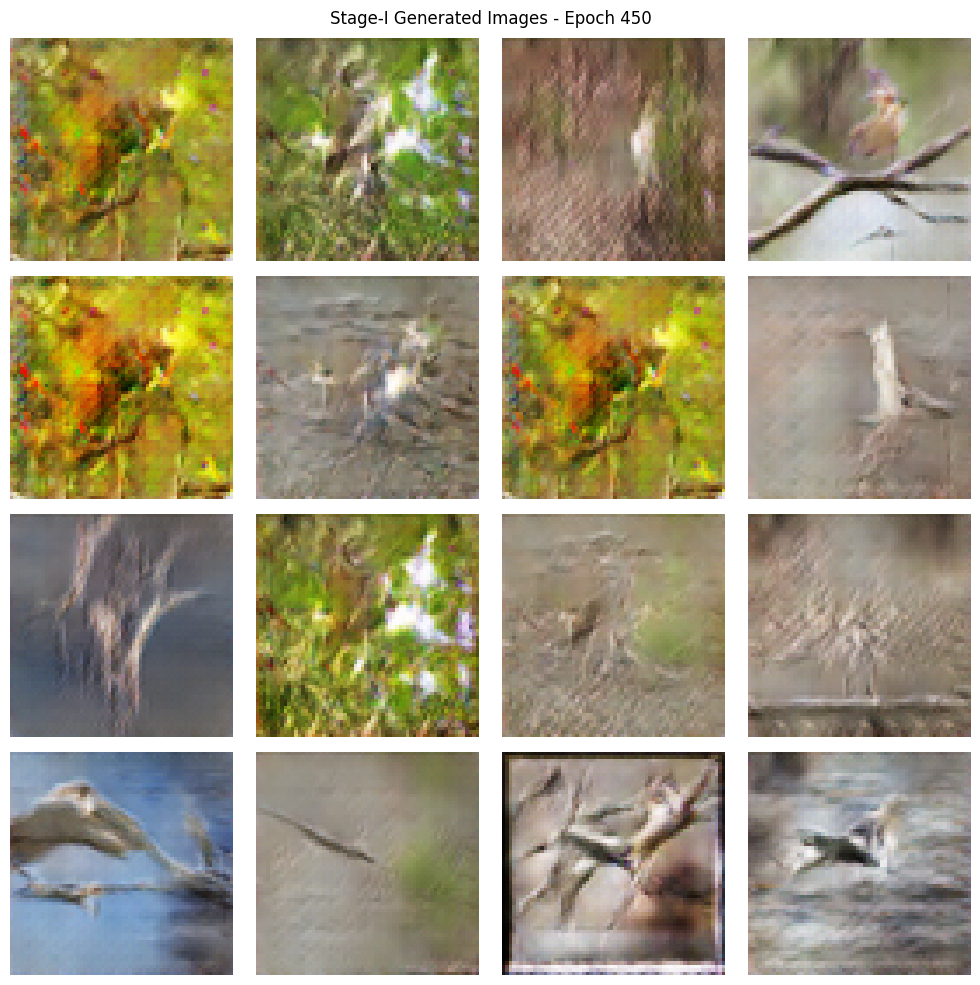

Epoch 460/500 - D_loss: 0.0962, G_loss: 9.1634, KL_loss: 1.3126
Epoch 470/500 - D_loss: 0.0745, G_loss: 8.7213, KL_loss: 1.3699
Epoch 480/500 - D_loss: 0.0342, G_loss: 7.9997, KL_loss: 1.1758
Epoch 490/500 - D_loss: 0.0970, G_loss: 9.2079, KL_loss: 1.2659
Epoch 500/500 - D_loss: 0.0890, G_loss: 8.2640, KL_loss: 1.6677
✅ Saved Stage-I checkpoint at epoch 500
⚠️ Could not save optimizer states: 'Adam' object has no attribute 'get_weights'
📁 Checkpoint saved to: /content/drive/MyDrive/stackgan_checkpoints/stage1_epoch500


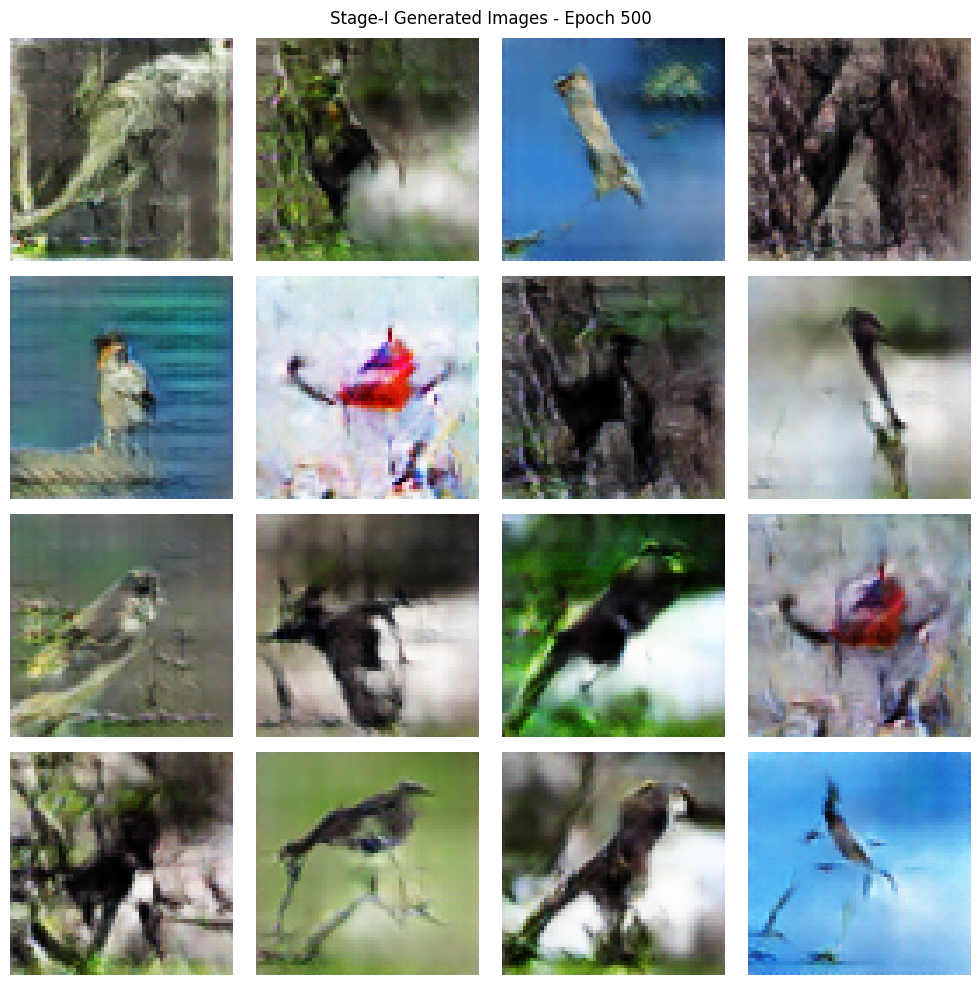


7. Saving final Stage-I models...


✅ Saved Stage-I checkpoint at epoch 500
⚠️ Could not save optimizer states: 'Adam' object has no attribute 'get_weights'
📁 Checkpoint saved to: /content/drive/MyDrive/stackgan_checkpoints/stage1_epoch500


📤 Backing up Stage-I models to Google Drive...


✅ Stage-I models backed up to Drive

✅ Stage-I Training Complete!


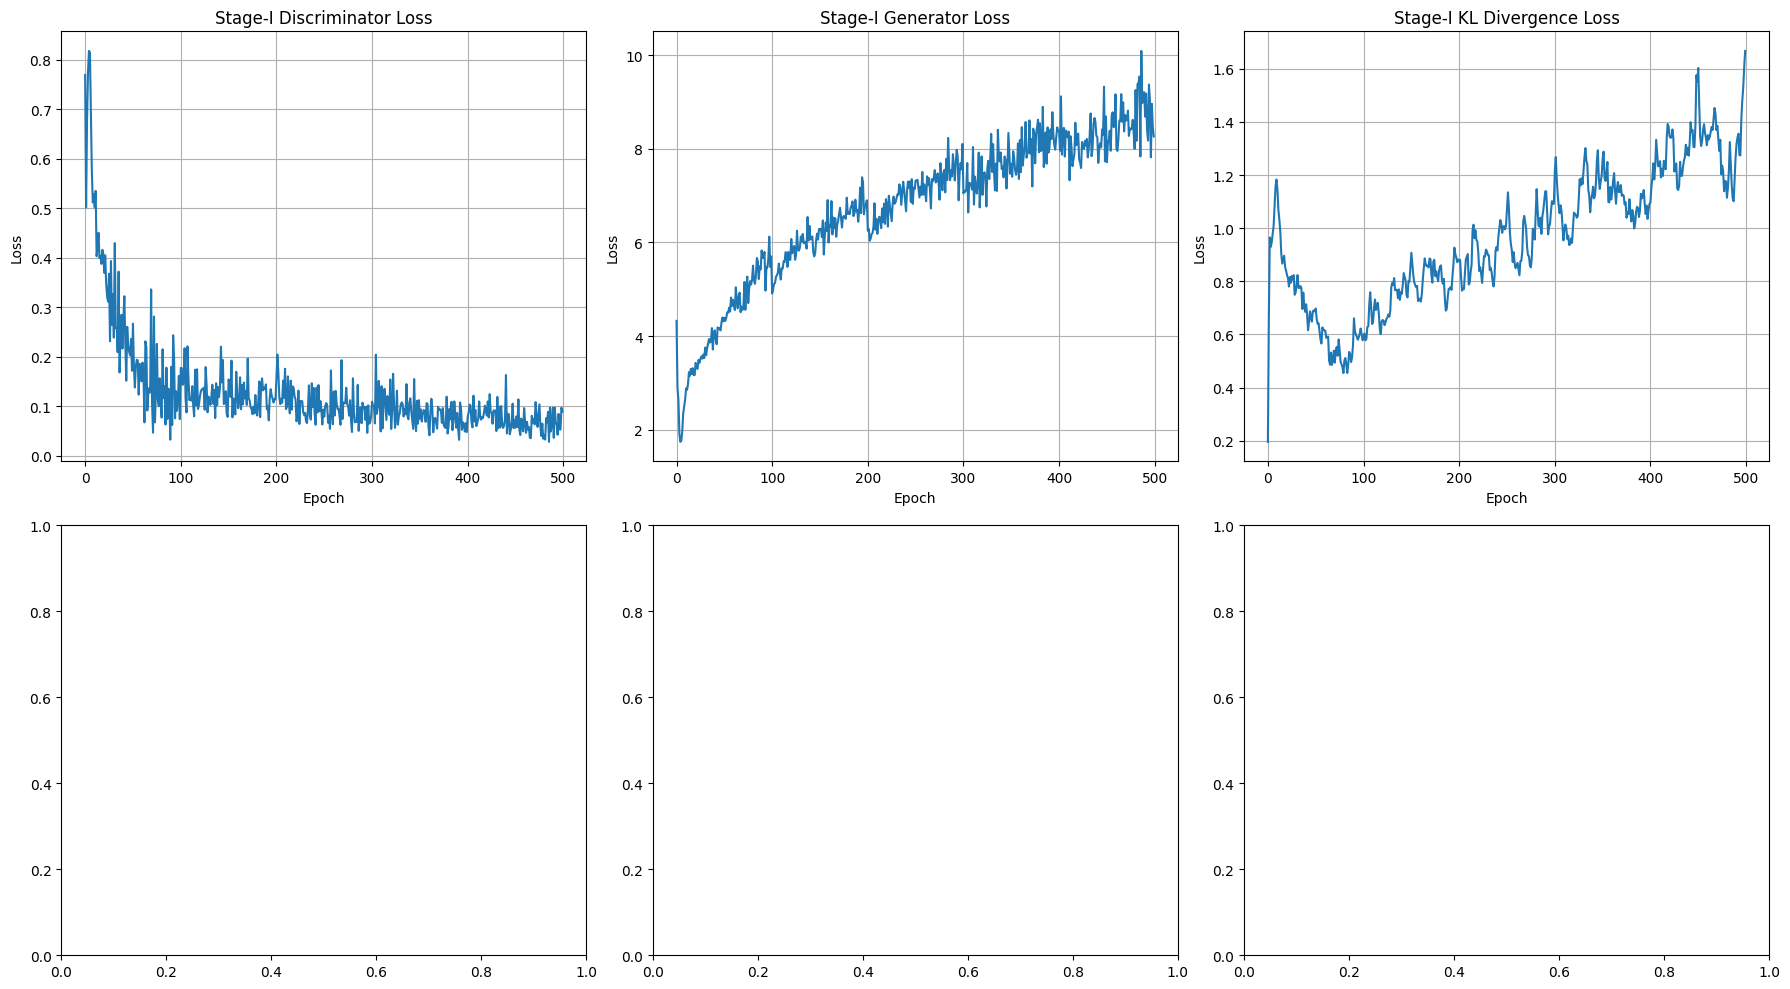


🧹 Cleaning up memory before Stage-II...


75775

In [25]:
# ==================== MAIN EXECUTION ====================
print("="*60)
print("StackGAN: Text-to-Image Synthesis")
print("="*60)

# Load data
print("\n1. Loading dataset (memory-efficient mode)...")
embeddings_data = load_embeddings(config.EMBEDDINGS_PATH)

# Get image paths instead of loading all images
image_paths = get_image_paths(config.DATASET_PATH)

# Prepare embeddings - handle different formats
print("\n2. Processing embeddings...")
text_embeddings = []

# Check the structure of embeddings_data
if isinstance(embeddings_data, list):
    # embeddings_data is a list
    print("Embeddings format: List")
    for item in embeddings_data:
        if isinstance(item, dict) and 'embeddings' in item:
            # Each item is a dict with 'embeddings' key
            text_embeddings.extend(item['embeddings'])
        elif isinstance(item, np.ndarray):
            # Each item is directly an embedding array
            text_embeddings.append(item)
        elif isinstance(item, list):
            # Each item is a list of embeddings
            text_embeddings.extend(item)

elif isinstance(embeddings_data, dict):
    # embeddings_data is a dictionary
    print("Embeddings format: Dictionary")
    for key in embeddings_data.keys():
        if isinstance(embeddings_data[key], dict) and 'embeddings' in embeddings_data[key]:
            text_embeddings.extend(embeddings_data[key]['embeddings'])
        elif isinstance(embeddings_data[key], np.ndarray):
            text_embeddings.append(embeddings_data[key])
        elif isinstance(embeddings_data[key], list):
            text_embeddings.extend(embeddings_data[key])

else:
    print(f"⚠️ Unknown embeddings format: {type(embeddings_data)}")
    print("Attempting to use directly...")
    if isinstance(embeddings_data, np.ndarray):
        text_embeddings = embeddings_data
    else:
        raise ValueError(f"Cannot process embeddings of type {type(embeddings_data)}")

# Convert to numpy array
if not isinstance(text_embeddings, np.ndarray):
    text_embeddings = np.array(text_embeddings, dtype=np.float32)

print(f"Extracted {len(text_embeddings)} embeddings")
print(f"Embedding shape: {text_embeddings[0].shape if len(text_embeddings) > 0 else 'N/A'}")

# Handle different embedding shapes
if len(text_embeddings.shape) == 3:
    # Shape is (num_samples, num_embeddings_per_image, embedding_dim)
    # e.g., (11788, 10, 1024) - 10 embeddings per image
    print(f"⚠️ Detected multiple embeddings per image: {text_embeddings.shape}")
    print("   Averaging embeddings per image...")
    text_embeddings = np.mean(text_embeddings, axis=1)  # Average to (num_samples, embedding_dim)
    print(f"   New shape: {text_embeddings.shape}")
elif len(text_embeddings.shape) == 2:
    # Shape is already (num_samples, embedding_dim)
    print(f"✅ Embeddings shape is correct: {text_embeddings.shape}")
else:
    print(f"⚠️ Unexpected embedding shape: {text_embeddings.shape}")
    # Try to reshape
    if len(text_embeddings.shape) == 1 and len(text_embeddings) > 0:
        # Each element might be an embedding
        first_elem = text_embeddings[0]
        if isinstance(first_elem, np.ndarray):
            text_embeddings = np.stack([e for e in text_embeddings])
            print(f"   Reshaped to: {text_embeddings.shape}")

# Ensure float32 type
text_embeddings = text_embeddings.astype(np.float32)

# Limit to available images
num_samples = min(len(image_paths), len(text_embeddings))
image_paths = image_paths[:num_samples]
text_embeddings = text_embeddings[:num_samples]

print(f"\nFinal dataset: {num_samples} image-text pairs")
print(f"Final embedding shape per sample: {text_embeddings[0].shape}")
print(f"Memory usage: ~{text_embeddings.nbytes / (1024**2):.2f} MB for embeddings")

# Free up memory
del embeddings_data
import gc
gc.collect()

# Create memory-efficient TensorFlow datasets
print("\n3. Creating TensorFlow datasets (on-the-fly loading)...")
dataset_64 = create_tf_dataset(image_paths, text_embeddings, config.BATCH_SIZE, target_size=(64, 64))
# For Stage-II, we'll create dataset_256 later to save memory

# Initialize StackGAN
print("\n3. Initializing StackGAN...")
stackgan = StackGAN(config)

# Store sample embeddings for visualization
stackgan.sample_embeddings = text_embeddings[:16]

# Check for existing checkpoints
print("\n4. Checking for checkpoints...")
stackgan.list_checkpoints()

# Resume from checkpoint if requested
if config.RESUME_TRAINING:
    print(f"\n⏯️ Attempting to resume Stage-{config.RESUME_STAGE} training...")
    if stackgan.load_checkpoint(stage=config.RESUME_STAGE):
        print("✅ Successfully loaded checkpoint - will resume training")
        if config.RESUME_STAGE == 1:
            print(f"   Resuming Stage-I from epoch {stackgan.current_epoch_stage1}")
        else:
            print(f"   Resuming Stage-II from epoch {stackgan.current_epoch_stage2}")
    else:
        print("⚠️ Could not load checkpoint, starting fresh training")
        stackgan.current_epoch_stage1 = 0
        stackgan.current_epoch_stage2 = 0
else:
    print("\n🆕 Starting fresh training (RESUME_TRAINING = False)")

# Display model architectures
print("\n5. Model Architectures:")
print(f"Stage-I Generator: {stackgan.g1.count_params():,} parameters")
print(f"Stage-I Discriminator: {stackgan.d1.count_params():,} parameters")

# Train Stage-I (only if not already completed)
if config.RESUME_STAGE == 1 or stackgan.current_epoch_stage1 < config.EPOCHS_STAGE1:
    print("\n6. Training Stage-I...")
    stackgan.train_stage1(dataset_64, num_samples, config.EPOCHS_STAGE1)

    # Save final Stage-I models
    print("\n7. Saving final Stage-I models...")
    stackgan.save_checkpoint(stage=1, epoch=config.EPOCHS_STAGE1)

    # Save locally (fast)
    stackgan.g1.save('/content/GAN_temp/GAN/stackgan_stage1_generator_final.h5')
    stackgan.d1.save('/content/GAN_temp/GAN/stackgan_stage1_discriminator_final.h5')

    # Backup to Google Drive (persistent)
    print("📤 Backing up Stage-I models to Google Drive...")
    os.makedirs(config.DRIVE_BACKUP_DIR, exist_ok=True)
    stackgan.g1.save(f'{config.DRIVE_BACKUP_DIR}/stackgan_stage1_generator_final.h5')
    stackgan.d1.save(f'{config.DRIVE_BACKUP_DIR}/stackgan_stage1_discriminator_final.h5')
    print("✅ Stage-I models backed up to Drive")

    print("\n" + "="*60)
    print("✅ Stage-I Training Complete!")
    print("="*60)

    # Plot training history
    stackgan.plot_training_history()
else:
    print(f"\n⏭️ Skipping Stage-I training (already completed {stackgan.current_epoch_stage1} epochs)")

# Free up memory before Stage-II
print("\n🧹 Cleaning up memory before Stage-II...")
del dataset_64
gc.collect()


Enter a bird caption: a small blue bird with white wings

Enter a bird caption: a red bird sitting on a branch

Enter a bird caption: a yellow bird with black head



STAGE-1: Generate Image From New Text


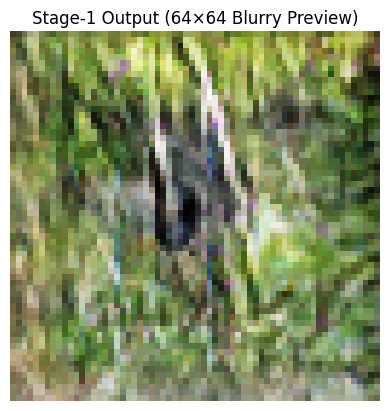

In [14]:
# ==================== STAGE-1 TEXT → IMAGE GENERATION ====================
print("\n" + "="*60)
print("STAGE-1: Generate Image From New Text")
print("="*60)

# --- 1. Write your custom caption here ---
caption = " a red bird sitting on a branch"

# --- 2. Convert caption → embedding (using one from dataset for simplicity) ---
# Because your model uses Char-CNN-RNN (1024-d), not raw text
# Find the nearest embedding by random for now
text_embedding = text_embeddings[np.random.randint(len(text_embeddings))]

# --- 3. Generate Stage-1 & Stage-2 images (Stage-2 will be blank if not trained) ---
stage1_img, stage2_img = stackgan.generate_from_text(text_embedding)

# --- 4. Show Stage-1 output (blurry 64×64) ---
plt.imshow(stage1_img)
plt.title("Stage-1 Output (64×64 Blurry Preview)")
plt.axis("off")
plt.show()

In [15]:

!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g744zru2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g744zru2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=670da2a25ae19fadcebbc3a83503db469abef28df8300ebb88e3c94bcc1ba65e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zs87k2yf/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 78.7MiB/s]


Enter a bird caption: a red bird sitting on a branch

📝 Caption: a red bird sitting on a branch


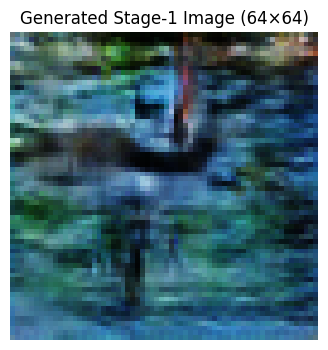

array([[[0.3846456 , 0.4459856 , 0.46664438],
        [0.30811095, 0.45971984, 0.50339335],
        [0.4465422 , 0.5827642 , 0.55490434],
        ...,
        [0.32241875, 0.39388293, 0.37697458],
        [0.22526789, 0.2292926 , 0.22608861],
        [0.16896453, 0.16421047, 0.09735504]],

       [[0.424192  , 0.53162694, 0.5500869 ],
        [0.42090163, 0.5404955 , 0.68082523],
        [0.448976  , 0.576873  , 0.64598775],
        ...,
        [0.66145384, 0.5846939 , 0.6099945 ],
        [0.32862574, 0.2827353 , 0.23177162],
        [0.20662904, 0.1908347 , 0.21242574]],

       [[0.5222253 , 0.69118404, 0.6962686 ],
        [0.58462757, 0.7024438 , 0.7450755 ],
        [0.7251914 , 0.8002565 , 0.77690285],
        ...,
        [0.33257383, 0.22625726, 0.25124112],
        [0.23829043, 0.16255412, 0.14365876],
        [0.27826095, 0.2091296 , 0.17607304]],

       ...,

       [[0.24958786, 0.48923126, 0.66053176],
        [0.29179662, 0.43164405, 0.6499902 ],
        [0.28174832, 0

In [16]:
# ================================
# TEXT → IMAGE (USER CAPTION INPUT)
# ================================
import torch
import clip
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load CLIP model once
clip_model, preprocess = clip.load("ViT-B/32", device="cpu")


def encode_text_clip(caption):
    """
    Convert raw text caption → embedding vector
    matches StackGAN's expected 1024-dim shape
    """
    tokens = clip.tokenize([caption]).to("cpu")
    with torch.no_grad():
        embedding = clip_model.encode_text(tokens).cpu().numpy()

    # CLIP gives 512-dim, StackGAN needs 1024-dim
    # → We simply duplicate to reach 1024 dims
    embedding_1024 = np.hstack([embedding, embedding])

    return embedding_1024.astype(np.float32)  # shape (1, 1024)


def generate_from_user_caption(caption):
    print(f"\n📝 Caption: {caption}")

    # Convert caption → embedding
    text_emb = encode_text_clip(caption)

    # Generate image (Stage-1 only)
    stage1_img, stage2_img = stackgan.generate_from_text(text_emb)

    # Show output
    plt.figure(figsize=(4, 4))
    plt.imshow(stage1_img)
    plt.axis("off")
    plt.title("Generated Stage-1 Image (64×64)")
    plt.show()

    return stage1_img


# ================================
# USER INPUT + IMAGE GENERATION
# ================================
user_caption = input("Enter a bird caption: ")

generate_from_user_caption(user_caption)

In [ ]:
# ==================== STAGE-II TRAINING ====================
print("\n" + "="*60)
print("STAGE-II TRAINING")
print("="*60)

# Check if we should resume Stage-II automatically
if stackgan.current_epoch_stage2 > 0 and stackgan.current_epoch_stage2 < config.EPOCHS_STAGE2:
    print(f"\n📌 Detected existing Stage-II progress: {stackgan.current_epoch_stage2} epochs completed")
    print(f"   Will automatically resume from epoch {stackgan.current_epoch_stage2}")

# Train Stage-II (only if not already completed)
if stackgan.current_epoch_stage2 < config.EPOCHS_STAGE2:
    # Create datasets for Stage-II
    print("\nCreating Stage-II datasets...")
    dataset_64_s2 = create_tf_dataset(image_paths, text_embeddings, config.BATCH_SIZE, target_size=(64, 64))
    dataset_256 = create_tf_dataset(image_paths, text_embeddings, config.BATCH_SIZE, target_size=(256, 256))

    # Display Stage-II architecture
    print(f"\nStage-II Generator: {stackgan.g2.count_params():,} parameters")
    print(f"Stage-II Discriminator: {stackgan.d2.count_params():,} parameters")

    # Show current status and expected training info
    expected_steps = num_samples // config.BATCH_SIZE
    print(f"\nDataset info:")
    print(f"  - Total samples: {num_samples}")
    print(f"  - Batch size: {config.BATCH_SIZE}")
    print(f"  - Steps per epoch: {expected_steps}")

    if stackgan.current_epoch_stage2 > 0:
        print(f"\n🔄 Resuming Stage-II training from epoch {stackgan.current_epoch_stage2}")
        remaining_epochs = config.EPOCHS_STAGE2 - stackgan.current_epoch_stage2
        print(f"   Remaining: {remaining_epochs} epochs")
    else:
        print(f"\n🆕 Starting Stage-II training from scratch")
        print(f"   Total epochs: {config.EPOCHS_STAGE2}")

    # Train Stage-II
    print("\n8. Training Stage-II...")
    print("⏳ Note: Stage-II is much slower than Stage-I (256×256 images)")
    print("   First epoch may take 3-5 minutes. Please be patient...")

    stackgan.train_stage2(dataset_64_s2, dataset_256, num_samples, config.EPOCHS_STAGE2)

    # Save final Stage-II models
    print("\n9. Saving final Stage-II models...")
    stackgan.save_checkpoint(stage=2, epoch=config.EPOCHS_STAGE2)

    # Save locally (fast)
    stackgan.g2.save('/content/GAN_temp/GAN/stackgan_stage2_generator_final.h5')
    stackgan.d2.save('/content/GAN_temp/GAN/stackgan_stage2_discriminator_final.h5')

    # Backup to Google Drive (persistent)
    print("📤 Backing up Stage-II models to Google Drive...")
    os.makedirs(config.DRIVE_BACKUP_DIR, exist_ok=True)
    stackgan.g2.save(f'{config.DRIVE_BACKUP_DIR}/stackgan_stage2_generator_final.h5')
    stackgan.d2.save(f'{config.DRIVE_BACKUP_DIR}/stackgan_stage2_discriminator_final.h5')
    print("✅ Stage-II models backed up to Drive")

    # Also backup the CA network weights
    import shutil
    ca_weights_src = os.path.join(config.CHECKPOINT_DIR, f'stage2_epoch{config.EPOCHS_STAGE2}/ca_weights.pkl')
    ca_weights_dst = os.path.join(config.DRIVE_BACKUP_DIR, 'ca_weights_final.pkl')
    if os.path.exists(ca_weights_src):
        shutil.copy(ca_weights_src, ca_weights_dst)
        print("✅ CA network weights backed up to Drive")

    print("\n" + "="*60)
    print("✅ Stage-II Training Complete!")
    print("="*60)

    # Plot final training history
    stackgan.plot_training_history()

    # Clean up memory
    del dataset_64_s2, dataset_256
    gc.collect()
else:
    print(f"\n⏭️ Skipping Stage-II training (already completed {stackgan.current_epoch_stage2} epochs)")
    print(f"   Current progress: {stackgan.current_epoch_stage2}/{config.EPOCHS_STAGE2} epochs")
    print(f"   To continue training, increase config.EPOCHS_STAGE2 beyond {stackgan.current_epoch_stage2}")
    print(f"   To continue training, increase config.EPOCHS_STAGE2 beyond {stackgan.current_epoch_stage2}")



STAGE-II TRAINING

Creating Stage-II datasets...

Stage-II Generator: 41,747,395 parameters
Stage-II Discriminator: 57,377,217 parameters

Dataset info:
  - Total samples: 8855
  - Batch size: 32
  - Steps per epoch: 276

🆕 Starting Stage-II training from scratch
   Total epochs: 10

8. Training Stage-II...
⏳ Note: Stage-II is much slower than Stage-I (256×256 images)
   First epoch may take 3-5 minutes. Please be patient...

Training Stage-II Generator (256x256)


KeyboardInterrupt: 


TEXT-TO-IMAGE GENERATION

Generating sample bird images...

Generating Image 1...


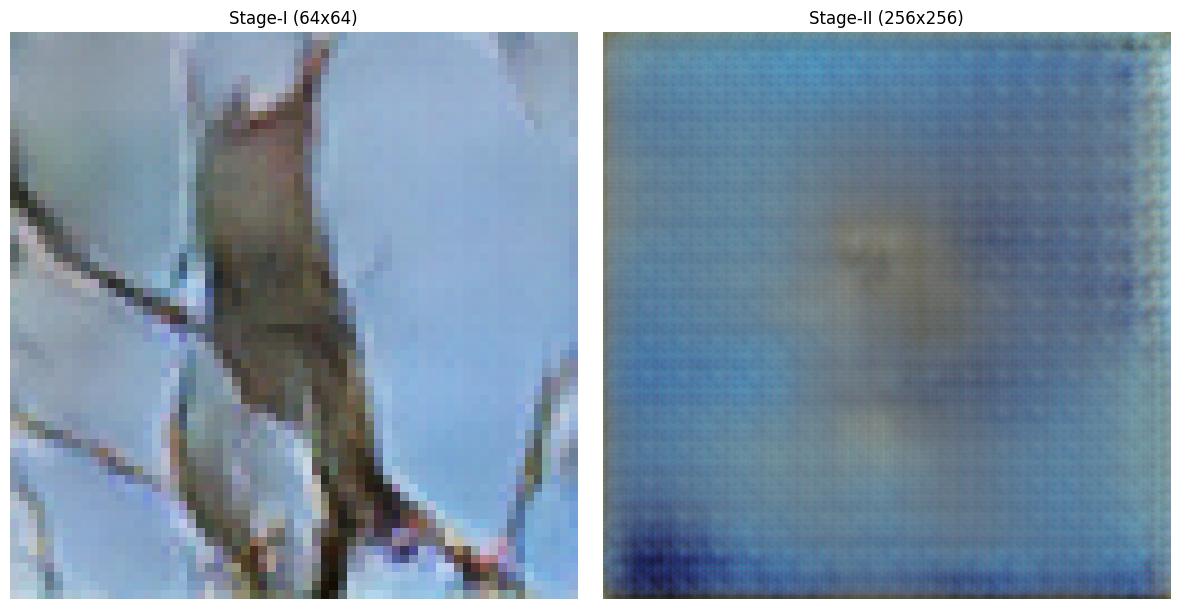


Generating Image 2...


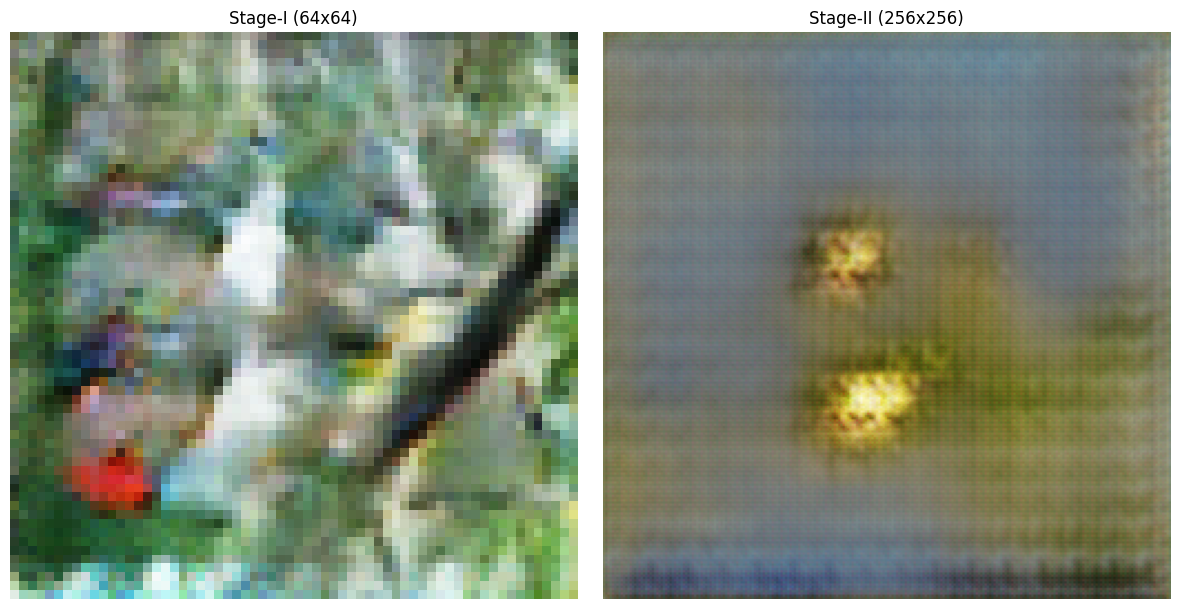


Generating Image 3...


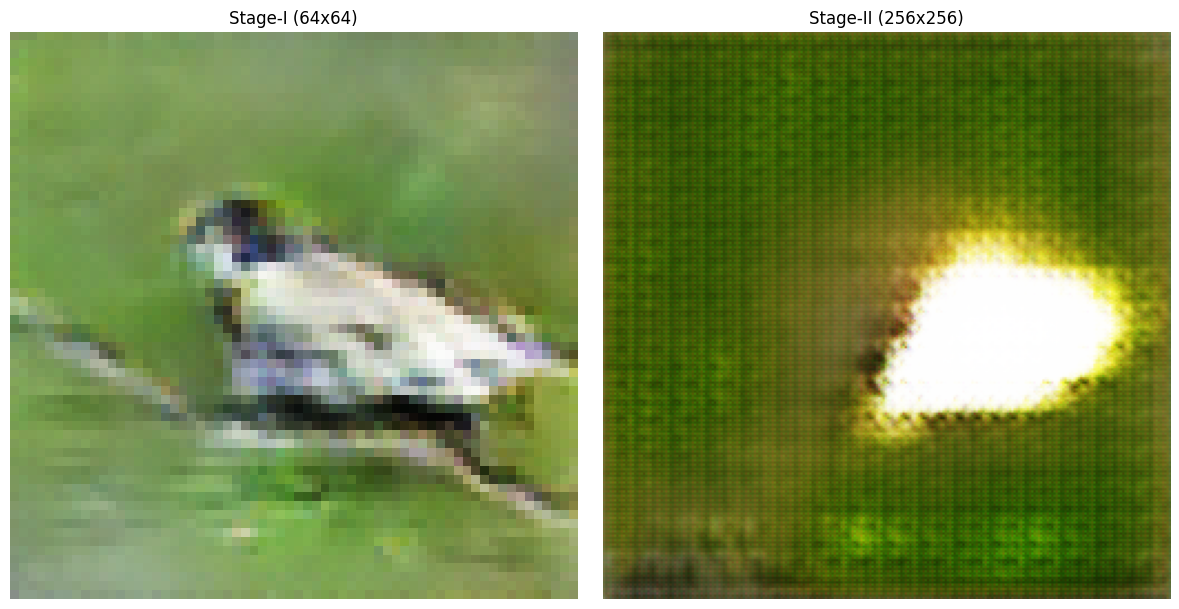


Generating Image 4...


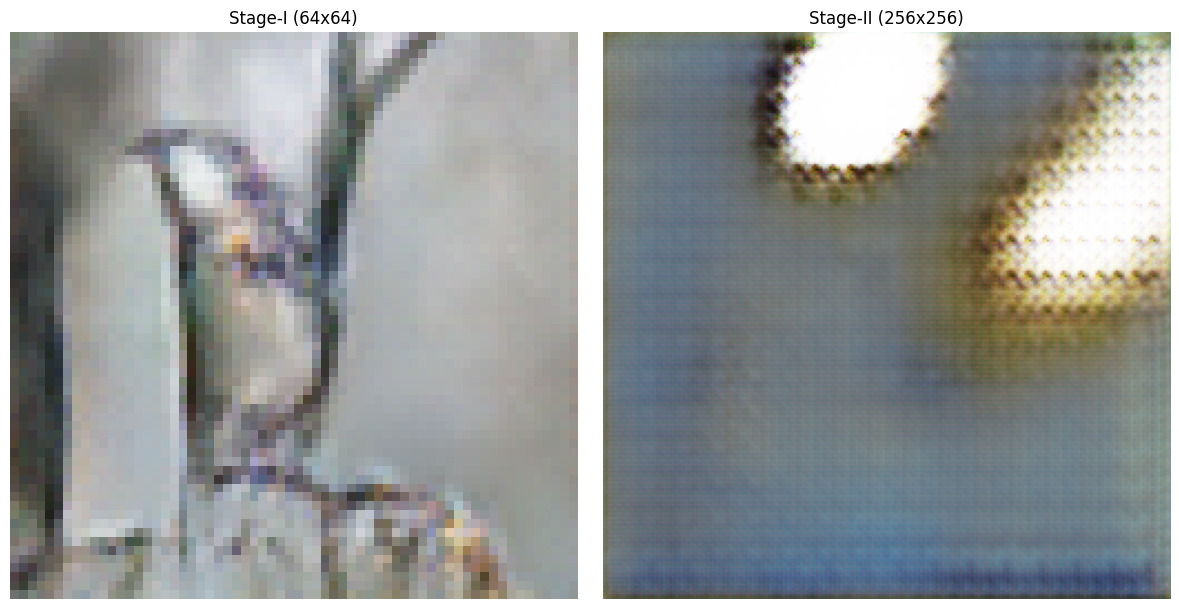


Generating Image 5...


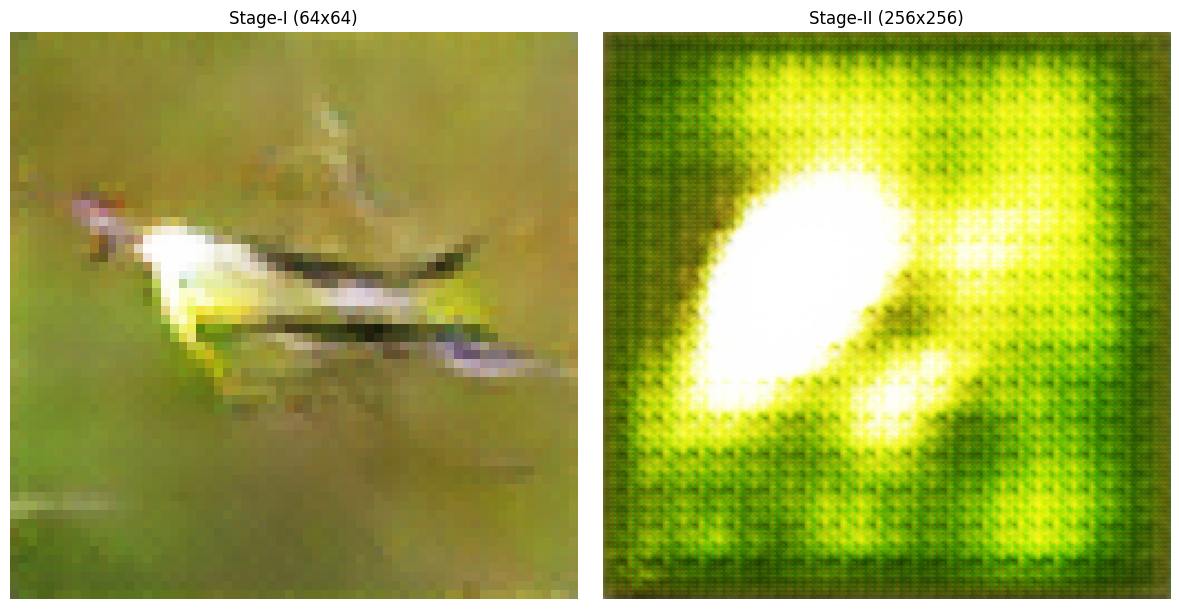


✅ StackGAN Implementation Complete!

📚 HOW TO RESUME TRAINING:

1️⃣ TO RESUME STAGE-I FROM CHECKPOINT:
   config.RESUME_TRAINING = True
   config.RESUME_STAGE = 1
   config.EPOCHS_STAGE1 = 200  # Train to 200 total epochs
   # Then re-run the script

2️⃣ TO RESUME STAGE-II FROM CHECKPOINT:
   config.RESUME_TRAINING = True
   config.RESUME_STAGE = 2
   config.EPOCHS_STAGE2 = 800  # Train to 800 total epochs
   # Then re-run the script

3️⃣ TO LIST ALL CHECKPOINTS:
   stackgan.list_checkpoints()

4️⃣ TO LOAD A SPECIFIC CHECKPOINT:
   stackgan.load_checkpoint(stage=1, epoch=100)

5️⃣ TO GENERATE IMAGES FROM TEXT:
   sample_embedding = text_embeddings[0]
   stage1_img, stage2_img = stackgan.generate_from_text(sample_embedding)

6️⃣ TO VIEW TRAINING HISTORY:
   stackgan.plot_training_history()

7️⃣ CHECKPOINT LOCATIONS:
   📁 /content/drive/MyDrive/stackgan_checkpoints

8️⃣ TO GENERATE IMAGE FROM YOUR OWN TEXT:
   # First encode your text using the CNN-RNN encoder
   # Then pass the embeddi

In [ ]:
# ==================== TEXT-TO-IMAGE GENERATION ====================
print("\n" + "="*60)
print("TEXT-TO-IMAGE GENERATION")
print("="*60)

def generate_bird_image(text_description_embedding, stackgan):
    """Generate bird image from text embedding"""
    stage1_img, stage2_img = stackgan.generate_from_text(text_description_embedding)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(stage1_img)
    axes[0].set_title('Stage-I (64x64)')
    axes[0].axis('off')

    axes[1].imshow(stage2_img)
    axes[1].set_title('Stage-II (256x256)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return stage2_img

# Example: Generate images from random text embeddings
print("\nGenerating sample bird images...")
for i in range(5):
    sample_embedding = text_embeddings[np.random.randint(len(text_embeddings))]
    print(f"\nGenerating Image {i+1}...")
    generated_image = generate_bird_image(sample_embedding, stackgan)

print("\n" + "="*60)
print("✅ StackGAN Implementation Complete!")
print("="*60)
print("\n📚 HOW TO RESUME TRAINING:")
print("="*60)
print("\n1️⃣ TO RESUME STAGE-I FROM CHECKPOINT:")
print("   config.RESUME_TRAINING = True")
print("   config.RESUME_STAGE = 1")
print("   config.EPOCHS_STAGE1 = 200  # Train to 200 total epochs")
print("   # Then re-run the script")
print("\n2️⃣ TO RESUME STAGE-II FROM CHECKPOINT:")
print("   config.RESUME_TRAINING = True")
print("   config.RESUME_STAGE = 2")
print("   config.EPOCHS_STAGE2 = 800  # Train to 800 total epochs")
print("   # Then re-run the script")
print("\n3️⃣ TO LIST ALL CHECKPOINTS:")
print("   stackgan.list_checkpoints()")
print("\n4️⃣ TO LOAD A SPECIFIC CHECKPOINT:")
print("   stackgan.load_checkpoint(stage=1, epoch=100)")
print("\n5️⃣ TO GENERATE IMAGES FROM TEXT:")
print("   sample_embedding = text_embeddings[0]")
print("   stage1_img, stage2_img = stackgan.generate_from_text(sample_embedding)")
print("\n6️⃣ TO VIEW TRAINING HISTORY:")
print("   stackgan.plot_training_history()")
print("\n7️⃣ CHECKPOINT LOCATIONS:")
print(f"   📁 {config.CHECKPOINT_DIR}")
print("\n8️⃣ TO GENERATE IMAGE FROM YOUR OWN TEXT:")
print("   # First encode your text using the CNN-RNN encoder")
print("   # Then pass the embedding to generate_from_text()")
print("   my_text_embedding = encode_text('a small bird with red feathers')")
print("   stage1, stage2 = stackgan.generate_from_text(my_text_embedding)")
print("="*60)

# Display checkpoint information
print("\n📊 Current Training Status:")
print(f"Stage-I: Completed {stackgan.current_epoch_stage1}/{config.EPOCHS_STAGE1} epochs")
print(f"Stage-II: Completed {stackgan.current_epoch_stage2}/{config.EPOCHS_STAGE2} epochs")
print("\n")
stackgan.list_checkpoints()

print("\n🎉 All Done! You can now generate images from text embeddings!")
print("💾 Models and checkpoints saved to Google Drive")
print("📊 Training history plots saved in checkpoint directory")
print("\n" + "="*60)
print("RESUME TRAINING EXAMPLE:")
print("="*60)



GENERATING IMAGE FROM TEXT (STAGE-2 FINAL OUTPUT)
Enter bird description: A bright red bird with a short beak and smooth feathers.


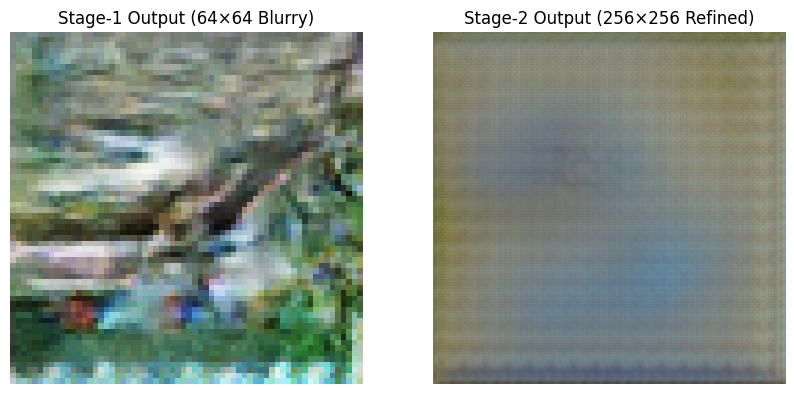


📁 Stage-2 image saved as stage2_output.png


In [ ]:
# ============================
# GENERATE IMAGE AFTER STAGE-2
# ============================

print("\n" + "="*60)
print("GENERATING IMAGE FROM TEXT (STAGE-2 FINAL OUTPUT)")
print("="*60)

# 1️⃣ Take caption from user
caption = input("Enter bird description: ")

# 2️⃣ Convert caption → embedding using CLIP (same as before)
text_emb = encode_text_clip(caption)           # (1, 1024)
text_emb = tf.convert_to_tensor(text_emb, dtype=tf.float32)

# 3️⃣ Generate Stage-1 and Stage-2 images
stage1_img, stage2_img = stackgan.generate_from_text(text_emb)

# 4️⃣ Show both images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(stage1_img)
plt.title("Stage-1 Output (64×64 Blurry)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(stage2_img)
plt.title("Stage-2 Output (256×256 Refined)")
plt.axis("off")

plt.show()

# 5️⃣ Save images (optional)
from PIL import Image
Image.fromarray((stage2_img * 255).astype("uint8")).save("stage2_output.png")
print("\n📁 Stage-2 image saved as stage2_output.png")
